In [50]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from datetime import datetime
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [3]:
pd.set_option('display.max_rows', 50)
warnings.simplefilter(action="ignore")

## Recognizing data

In [4]:
df_ = pd.read_csv('/Users/hikmetselimtalu/Desktop/data/municipality_bus_utilization.csv')

In [5]:
df = df_.copy()

In [6]:
df.shape

(13070, 4)

In [7]:
df.head(20)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [8]:
df['timestamp'].min(), df['timestamp'].max()  #  Saturday - Sunday

('2017-06-04 07:59:42', '2017-08-19 16:30:35')

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp', ascending=True)
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [10]:
df = df.set_index('timestamp')
df = df.groupby('municipality_id').resample('H').max()

In [11]:
df.head()

municipality_id  usage  total_capacity
municipality_id timestamp                                                  
0               2017-06-04 07:00:00              0.0  204.0          2813.0
                2017-06-04 08:00:00              0.0  332.0          2813.0
                2017-06-04 09:00:00              0.0  485.0          2813.0
                2017-06-04 10:00:00              0.0  583.0          2813.0
                2017-06-04 11:00:00              0.0  614.0          2813.0

In [12]:
df = df[['usage', 'total_capacity']].reset_index()

### To seperate the date

In [14]:
def add_datepart(df, dt_name, drop=True, time=False):
    "Creates new columns from our datetime column"
    
    
    dt_column = df[dt_name]
    column_dtype = dt_column.dtype
    

    targ_name = re.sub('[Dd]ate$', '', dt_name)
    

    attr = ['Month', 'Week', 'Day', 'Dayofweek']
    
    if time: 
        attr = attr + ['Hour']
        
    
    for a in attr: 
        df[a] = getattr(dt_column.dt, a.lower())
        
    if drop: 
        df.drop(dt_name, axis=1, inplace=True)

In [15]:
add_datepart(df, 'timestamp', drop=False, time=True)

In [18]:
df.head(20)

,municipality_id,timestamp,usage,total_capacity,Month,Week,Day,Dayofweek,Hour
0,0,2017-06-04 07:00:00,204.0,2813.0,6,22,4,6,7
1,0,2017-06-04 08:00:00,332.0,2813.0,6,22,4,6,8
2,0,2017-06-04 09:00:00,485.0,2813.0,6,22,4,6,9
3,0,2017-06-04 10:00:00,583.0,2813.0,6,22,4,6,10
4,0,2017-06-04 11:00:00,614.0,2813.0,6,22,4,6,11
5,0,2017-06-04 12:00:00,613.0,2813.0,6,22,4,6,12
6,0,2017-06-04 13:00:00,605.0,2813.0,6,22,4,6,13
7,0,2017-06-04 14:00:00,585.0,2813.0,6,22,4,6,14
8,0,2017-06-04 15:00:00,520.0,2813.0,6,22,4,6,15
9,0,2017-06-04 16:00:00,470.0,2813.0,6,22,4,6,16


In [19]:
df.isna().sum()

municipality_id        0
timestamp              0
usage              11600
total_capacity     11600
Month                  0
Week                   0
Day                    0
Dayofweek              0
Hour                   0
dtype: int64

### Filter according to working hours

In [20]:
df = df.loc[(df['Hour'] >= 7) & (df['Hour'] <= 16)].reset_index(drop=True)

In [21]:
df.head()

,municipality_id,timestamp,usage,total_capacity,Month,Week,Day,Dayofweek,Hour
0,0,2017-06-04 07:00:00,204.0,2813.0,6,22,4,6,7
1,0,2017-06-04 08:00:00,332.0,2813.0,6,22,4,6,8
2,0,2017-06-04 09:00:00,485.0,2813.0,6,22,4,6,9
3,0,2017-06-04 10:00:00,583.0,2813.0,6,22,4,6,10
4,0,2017-06-04 11:00:00,614.0,2813.0,6,22,4,6,11


In [22]:
df.isna().sum()

municipality_id      0
timestamp            0
usage              960
total_capacity     960
Month                0
Week                 0
Day                  0
Dayofweek            0
Hour                 0
dtype: int64

### Fill na values for total_capacity

In [23]:
sub_df = df.groupby('municipality_id')['total_capacity'].max()
sub_df

municipality_id
0    2813.0
1     397.0
2     697.0
3    1930.0
4    3893.0
5     587.0
6    3113.0
7    2019.0
8    2947.0
9    1332.0
Name: total_capacity, dtype: float64

In [24]:
df.loc[:, 'total_capacity'] = df['municipality_id'].map(sub_df)
df.isna().sum()

municipality_id      0
timestamp            0
usage              960
total_capacity       0
Month                0
Week                 0
Day                  0
Dayofweek            0
Hour                 0
dtype: int64

# Interpolate

I used week 31 to see linear interpolation. And It has 32 missing data

In [27]:
a = df[df['usage'].isna()].groupby(['Week', 'municipality_id']).count()
a[a['timestamp'] == 32]

timestamp  usage  total_capacity  Month  Day  Dayofweek  \
Week municipality_id                                                            
31   0                       32      0              32     32   32         32   
     1                       32      0              32     32   32         32   
     2                       32      0              32     32   32         32   
     3                       32      0              32     32   32         32   
     4                       32      0              32     32   32         32   
     5                       32      0              32     32   32         32   
     6                       32      0              32     32   32         32   
     7                       32      0              32     32   32         32   
     8                       32      0              32     32   32         32   
     9                       32      0              32     32   32         32   

                      Hour  
Week municipality_id        
31   0                  32  
     1                  32  
     2                  32  
     3                  32  
     4                  32  
     5                  32  
     6                  32  
     7                  32  
     8                  32  
     9                  32

In [28]:
df_lin = df.groupby('municipality_id').apply(lambda x: x.interpolate(method='linear'))

### Graph of linear interpolation and moving average

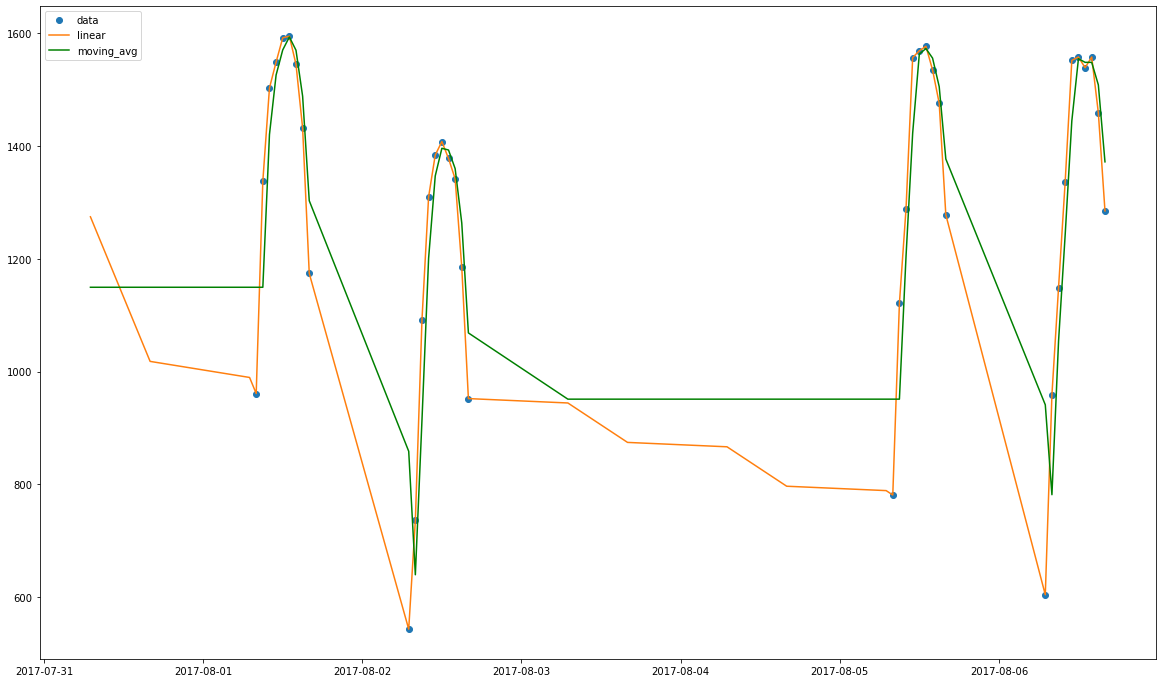

In [29]:
x = df.loc[(df['Week'] == 31) & (df['municipality_id'] == 3), 'timestamp']
y = df.loc[(df['Week'] == 31) & (df['municipality_id'] == 3), 'usage']
y_lin = df_lin.loc[(df_lin['Week'] == 31) & (df_lin['municipality_id'] == 3), 'usage']
df_ma = df.copy()
df_ma['usage'] = df['usage'].rolling(window=2).mean().bfill()
y_ma = df_ma.loc[(df_ma['Week'] == 31) & (df_ma['municipality_id'] == 3), 'usage']

plt.figure(figsize=(20,12))
plt.plot(x, y, 'o', x, y_lin, x, y_ma, 'g')
plt.legend(['data', 'linear', 'moving_avg'], loc='best')
plt.show();

In [30]:
df = df_lin.copy()
round(df.groupby('municipality_id')['usage'].agg(['min', 'mean', 'max', 'std']), 2)

,min,mean,max,std
municipality_id,,,,
0,70.0,547.41,1543.0,241.10
1,61.0,296.27,412.0,89.37
2,185.0,486.55,697.0,118.09
3,267.0,1069.11,1646.0,358.72
4,481.0,2293.38,3508.0,847.94
5,12.0,167.74,582.0,98.68
6,399.0,1019.39,1920.0,285.68
7,510.0,1142.12,1923.0,268.88
8,342.0,1015.13,1476.0,285.07


There is not missing data anymore

In [31]:
df.isna().sum()

municipality_id    0
timestamp          0
usage              0
total_capacity     0
Month              0
Week               0
Day                0
Dayofweek          0
Hour               0
dtype: int64

## Feature Engineering

In [34]:
num_but_cat = [col for col in df.columns if df[col].nunique() < 20 and df[col].dtypes != "O" and 
               col not in ['timestamp', 'total_capacity']]
num_but_cat

['municipality_id', 'Month', 'Week', 'Dayofweek', 'Hour']

This is unique values according to categorical columns

In [33]:
for i in num_but_cat:
    print(i, ':', df[i].unique())

municipality_id : [0 1 2 3 4 5 6 7 8 9]
Month : [6 7 8]
Week : [22 23 24 25 26 27 28 29 30 31 32 33]
Dayofweek : [6 0 1 2 3 4 5]
Hour : [ 7  8  9 10 11 12 13 14 15 16]


In [36]:
df['is_weekend'] = np.where((df['Dayofweek'] == 5) | (df['Dayofweek'] == 6), 1, 0)
df.head(2)

,municipality_id,timestamp,usage,total_capacity,Month,Week,Day,Dayofweek,Hour,is_weekend
0,0,2017-06-04 07:00:00,204.0,2813.0,6,22,4,6,7,1
1,0,2017-06-04 08:00:00,332.0,2813.0,6,22,4,6,8,1


In [37]:
df['is_weekend'].value_counts() # Weekend or not

0    5500
1    2200
Name: is_weekend, dtype: int64

In [38]:
df['usage_ratio'] = round(df['usage'] / df['total_capacity'], 3)
df.head(3)

,municipality_id,timestamp,usage,total_capacity,Month,Week,Day,Dayofweek,Hour,is_weekend,usage_ratio
0,0,2017-06-04 07:00:00,204.0,2813.0,6,22,4,6,7,1,0.073
1,0,2017-06-04 08:00:00,332.0,2813.0,6,22,4,6,8,1,0.118
2,0,2017-06-04 09:00:00,485.0,2813.0,6,22,4,6,9,1,0.172


In [40]:
test_index = df[(df['timestamp'] < datetime.strptime('2017-08-19', '%Y-%m-%d')) & 
                (df['timestamp'] > datetime.strptime('2017-08-05', '%Y-%m-%d'))].index
train_index = df[~df.index.isin(test_index)].index

In [41]:
test = df.iloc[test_index]
train = df.iloc[train_index]
train.shape, test.shape

((6300, 11), (1400, 11))

In [42]:
val = train[train['Week'].isin([33, 32 ,31, 30])]
train = train[~train['Week'].isin([33, 32 ,31, 30])]

In [44]:
Y_test = test['usage']
X_test = test.drop('usage', axis = 1).set_index('timestamp')
Y_train = train['usage']
X_train = train.drop('usage', axis = 1).set_index('timestamp')
Y_val = val['usage']
X_val = val.drop('usage', axis = 1).set_index('timestamp')

Y_test.shape, X_test.shape, Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((1400,), (1400, 9), (5000,), (5000, 9), (1300,), (1300, 9))

In [45]:
cols = X_train.columns.to_list()
cols

['municipality_id',
 'total_capacity',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Hour',
 'is_weekend',
 'usage_ratio']

In [46]:
lgb_params = {'metric': {'mae'},
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'verbose': 10000,
              'num_boost_round': 5000,
              'early_stopping_rounds': 100,
              'min_data_in_leaf':50,
              'bagging_freq':10,
              'max_depth':10,
              'nthread': -1}

In [47]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [48]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.104444
[LightGBM] [Debug] init for col-wise cost 0.000257 seconds, init for row-wise cost 0.001974 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training fr

           feature  split       gain
1   total_capacity  15665  48.917691
8      usage_ratio  54860  29.982967
0  municipality_id  13442  15.993743
5        Dayofweek  14372   2.315658
6             Hour  16793   2.129273
4              Day  21560   0.339258
3             Week   8811   0.109142
2            Month   2348   0.107945
7       is_weekend    658   0.104322


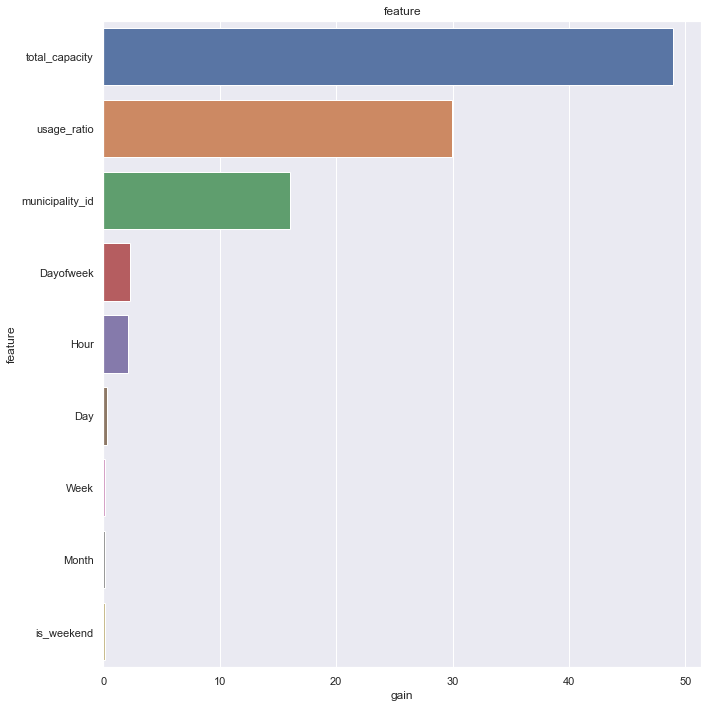

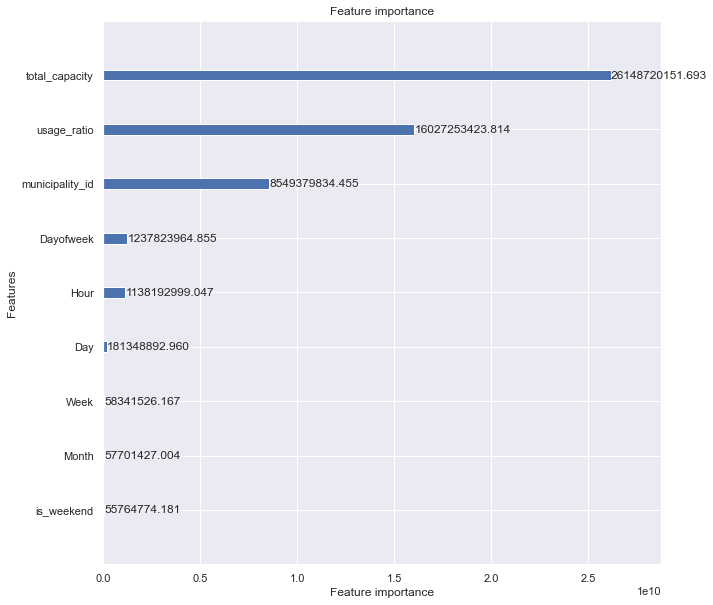

In [49]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)

plot_lgb_importances(model, plot=True, num=30)



lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [51]:
Y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [52]:
mean_absolute_error(Y_test, Y_pred)

16.712129817907634

# NOTE

* Model created without one-hot encoding for categorical columns and very little feature engineering has been done. And I think, the model I created was overfit

* I couldn't do most of what I wanted to do as I only had 5 days to complete these and questions.

* If I had more time I was going to add lag values, moving averages and random noise to the dataset in part of feature engineering. And I was going to add dummy variables for categorical columns

* At the model stage, I could create an classical models and decompose the time series according to trend, seasonality, wava and errors. Especially I could create 'Triple Exponential Smoothing Method' 

* Then I could compare two models 